In [1]:
from manager import load_obj
import os
import re
import string
from collections import Counter
from pprint import pprint
from tqdm.notebook import tqdm
from itertools import combinations

In [2]:
works = load_obj("germanistik")

In [3]:
index_work = {}
for index,work in enumerate(works):
    index_work[work.link.split("/")[-1]] = index

In [4]:
def find_tag(text, tag):
    
    reg_start = re.compile(fr"(\<{tag}\>)")
    reg_end =  re.compile(fr"(\<\/{tag}\>)")
    start = [m.start() for m in re.finditer(reg_start, text)]
    end = [m.start() for m in re.finditer(reg_end, text)]
    
    aut=""
    if start and end:
        for s,e in zip(start,end):
            aut += re.sub(r"<[^>]*>", "", text[s:e] + "  ")
    else:
        aut = ""
    return aut

In [5]:
def create_ref_dic(text, count):
    references ={"autoren": []}
    refs = text.split("</sequence>")[:-1]
    
    for ref in refs:
        if (len(find_tag(ref, "author")) != 0):
            count +=1
        
        
        text = find_tag(ref, "author")
        authors = re.split("  |\/", text)
        authors = [x for x in authors if len(x) > 0]
        if len(authors) != 0:
            references["autoren"] += authors
    return (references, count)

In [6]:
path = r"C:\Users\Tim\Desktop\bachelorarbeit\Parsed_References"
c = 0
num = 0
for filename in os.listdir(r"C:\Users\Tim\Desktop\bachelorarbeit\Parsed_References"):
    with open(os.path.join(path, filename), 'r', encoding = "utf-8") as f: # open in readonly mode
        name = os.path.basename(f.name).split(".")[0]
        num += 1
        if index_work.get(name) != None:
            works[index_work.get(name)].ref_authors, c  = create_ref_dic(f.read(), c)
        

In [7]:
print("Anzahl der Referenzen: " + str(c))
print("Anzahl der Arbeiten: " + str(num))

Anzahl der Referenzen: 8218
Anzahl der Arbeiten: 1034


# Statistics of author occurrences

In [8]:
def compare_names(author, dic):
    new_dic = dic
    namelist = list(new_dic.keys())
    count = 0
    appended = False
    if len(namelist) != 0:
        
        for nam in namelist:
            if is_author(author, nam):
                count = 0
                for entry in new_dic[nam]:
                    if is_author(author, entry):
                        count += 1
                
                if count/len(new_dic[nam]) >= 0.7:
                    new_dic[nam] += [author]
                    return new_dic
                else:
                    new_dic[nam] = [author]
                    return new_dic
            else:
                continue
        new_dic[author]=[author]
        return new_dic
                
    else:
        new_dic[author] = [author]
        return new_dic

In [9]:
def is_author(author, compare):
    name = author.split(" ")
    name = list(filter(None, name))
    name_compare = compare.split(" ")
    name_compare = list(filter(None, name_compare))
    flag = False
    full_name_flag = False
    if len(name) >= len(name_compare):
        prob = len(name_compare)
        tmp = name_compare
        name_compare = name
        name = tmp
    else:
        prob = len(name)
    new_prob = 0   

    beginners_n = [x[0] for x in name]
    beginners_nc = [x[0] for x in name_compare]
    
    
    
    for n in beginners_n:
        if n in beginners_nc:
            beginners_nc.remove(n)
        else:
            return False
            
    for i, n in enumerate(name):
            
            for j,nc in enumerate(name_compare):
                if (i==j) and (nc == n):
                    new_prob +=1
            
            if new_prob/prob > 0.5:
                return True
            
            elif n[0] not in (x[0] for x in name_compare):
                flag = False
                break

                
            elif (len(n) > 1) and n in name_compare:
                flag = True
                full_name_flag = True
    
            else:
              
                for nc in name_compare:
                    if (n[0] == nc[0]) and ((len(nc) == 1) or (len(n) == 1)):
                        flag = True    
                        
                    elif(n[0] == nc[0]):
                        control = min(len(n), len(nc))
                        if n[:control]!= nc[:control]:
                            return False
                    
                    
    if flag and full_name_flag:
        return True
    else:
        return False

In [10]:

authors = []
ref_per_author = {}
appended = False
ref_len = 0
### per document only one author
for work in tqdm(works):
    if work.references != "none" and work.link.split("/")[-1] != "283936":
       

        dics = {}
        ## if author longer than 6 skip name!!
       
        auts = [x.lower() for x in work.ref_authors["autoren"]]
       
        auts = [x.translate(str.maketrans('', '', string.punctuation)) for x in auts]
        
        
        for aut in auts:
            if len(aut.split(" ")) >= 5 or aut == "" or len(aut.split(" ")) == 1:
                continue
                
            dics = compare_names(aut, dics)
            ref_len +=1
        
        for key, value in dics.items():
            namlist = ref_per_author.keys()
            for nam in namlist:
                if is_author(key, nam):
                    ref_per_author[nam].append(len(value))
                    appended = True
                    break
            if not appended:
                ref_per_author[key] = [len(value)]
            appended = False
        
        authors += list(dics.keys())

print("Absolute Anzahl von Autorenerwähnung: " + str(ref_len))

final_dic = {}
for aut in tqdm(authors):
    final_dic = compare_names(aut, final_dic) 

print("Anzahl unterschiedlicher Autoren: " + str(len(final_dic.keys())))  


  0%|          | 0/1028 [00:00<?, ?it/s]

Absolute Anzahl von Autorenerwähnung: 7939


  0%|          | 0/6921 [00:00<?, ?it/s]

Anzahl unterschiedlicher Autoren: 5218


In [11]:
result = dict(sorted(final_dic.items(), key=lambda item: len(item[1]), reverse = True))

In [12]:
final_result = {}
for key, value in result.items():
    final_result[key] = len(value)

In [13]:

final_result["hartmann von aue"] = final_result.pop("hartmann von")
final_result['mann thomas'] = final_result.pop("mann thomas „der")
final_result = dict(sorted(final_result.items(), key=lambda item: item[1], reverse = True))

In [15]:
c=0
for k,v in final_result.items():
    if v ==1:
        c+=1
print("Anzahl der Autor:innen die nur einmal erwähnt werden: " +  str(c))

Anzahl der Autor:innen die nur einmal erwähnt werden: 4395


# Zipf Distribution of author occurrences


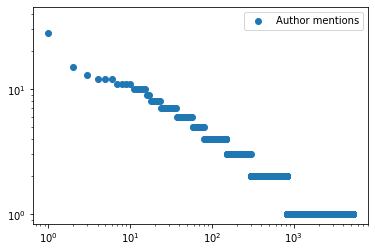

In [17]:
import matplotlib.pyplot as plt
x = len(final_result)
y = sorted(final_result.values(), reverse=True)
plt.scatter(range(x), y,label="Author mentions")
plt.yscale('log')
plt.xscale('log')
plt.legend()